In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps

from scipy.integrate import solve_ivp

In [2]:
data = np.load("/export/data/isulzer/DON-vs-NODE/data/osu2008/train_data.npy")
data.shape

(800, 100, 29)

In [3]:
data = data - data.mean(axis=(0,1))
# data = data.reshape((800*100), 29)
data.shape

(800, 100, 29)

In [4]:
u, s, vh = np.linalg.svd(data, full_matrices=False)
print(u.shape, s.shape, vh.shape)

(800, 100, 29) (800, 29) (800, 29, 29)


<BarContainer object of 29 artists>

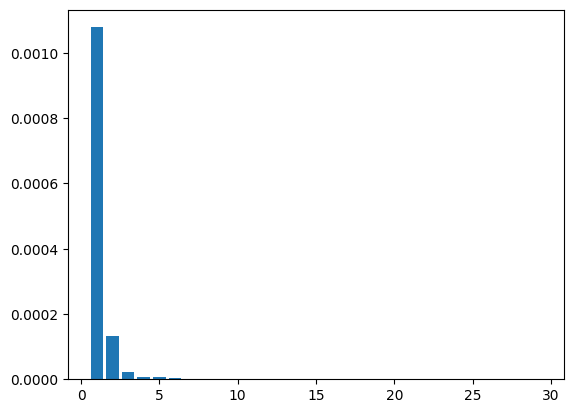

In [5]:
variances = s**2 / (data.shape[0]-1)
explained_variances = variances / np.sum(variances)

var_mean = explained_variances.mean(axis=0)

plt.bar(range(1, len(var_mean)+1), var_mean)

In [6]:
ndims = 15

b = u[:,:,:ndims] * s[:,None,:ndims] # reduced data
print(b.shape)
reconstructed = b @ vh[:,:ndims,:]
print(reconstructed.shape) # reconstructed data

(800, 100, 15)
(800, 100, 29)


Text(0.5, 1.0, 'Reconstructed data')

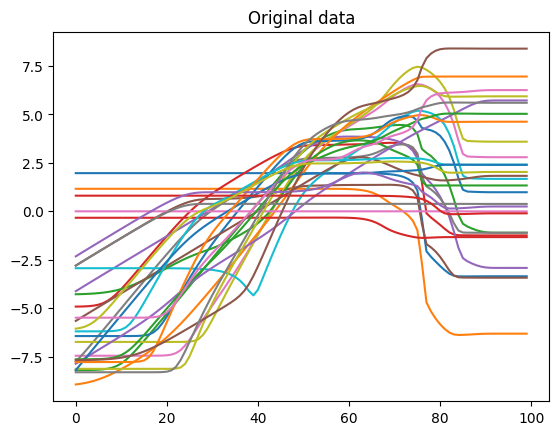

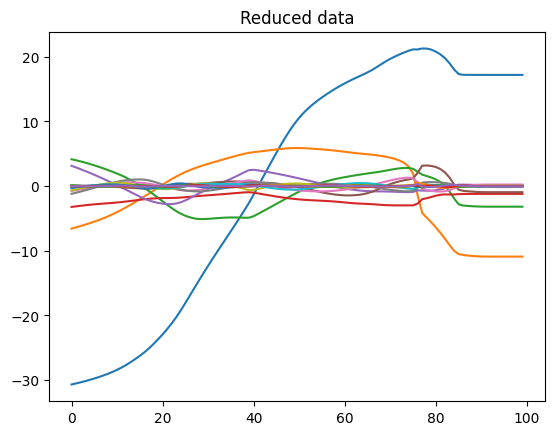

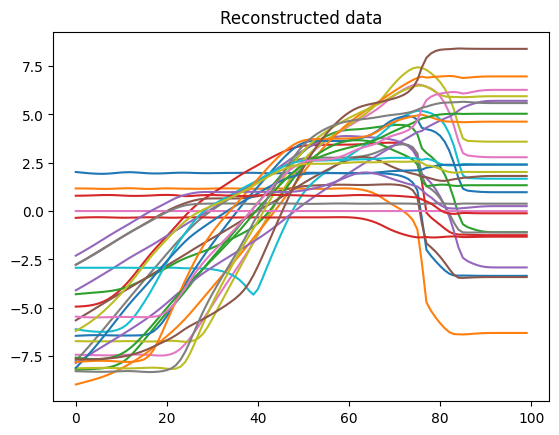

In [7]:
def plot_data(data):
    plt.figure()
    species = data.shape[-1]
    for i in range(species):
        plt.plot(data[:,i])

idx = 0
plot_data(data[idx])
plt.title("Original data")
plot_data(b[idx])
plt.title("Reduced data")
plot_data(reconstructed[idx])
plt.title("Reconstructed data")

In [21]:
from sklearn.utils.validation import check_is_fitted
from sklearn import __version__
from scipy.interpolate import interp1d
import warnings
from torchdiffeq import odeint
from torch import nn
import torch

class SindyModel(ps.SINDy):

    def simulate(
        self,
        x0,
        t,
        u=None,
        integrator="solve_ivp",
        stop_condition=None,
        interpolator=None,
        integrator_kws={"method": "LSODA", "rtol": 1e-12, "atol": 1e-12},
        interpolator_kws={},
    ):
        check_is_fitted(self, "model")
        if u is None and self.n_control_features_ > 0:
            raise TypeError("Model was fit using control variables, so u is required")

        
        if np.isscalar(t):
            raise ValueError(
                "For continuous time model, t must be an array of time"
                " points at which to simulate"
            )

        class RHS(nn.Module):

            def __init__(self, model):
                super().__init__()
                self.model = model

            def forward(self, t, x):
                x = np.array(x)
                return torch.tensor(self.model.predict(x[np.newaxis, :])[0])
            
        rhs = RHS(self)


        # Need to hard-code below, because odeint and solve_ivp
        # have different syntax and integration options.
        if integrator == "solve_ivp":
            return (
                (solve_ivp(rhs, (t[0], t[-1]), x0, t_eval=t, **integrator_kws)).y
            ).T
        elif integrator == "odeint":
            if integrator_kws.get("method") == "LSODA":
                integrator_kws = {}
            x0 = torch.tensor(x0, dtype=torch.float64)
            t = torch.tensor(t, dtype=torch.float64)
            return odeint(rhs, x0, t, method='fehlberg2', rtol=1e-4, atol=1e-5)
        else:
            raise ValueError("Integrator not supported, exiting")

In [22]:
latent_trajectories = []
for i in range(b.shape[0]):
    latent_trajectories.append(b[i])

t_steps = np.linspace(0, 1, 100)

model = SindyModel() #ps.SINDy()
model.fit(latent_trajectories, t=t_steps, multiple_trajectories=True)
model.print()

(x0)' = 88.131 1 + -1.787 x0 + 0.898 x2 + -0.890 x3 + 1.081 x4 + -0.549 x5 + 3.955 x6 + 3.245 x7 + 0.883 x8 + 1.945 x9 + -3.022 x10 + -1.292 x11 + 5.296 x12 + -3.360 x13 + -6.282 x14 + -0.133 x0^2 + 0.169 x0 x2 + 0.157 x0 x6 + 0.190 x0 x8 + 0.252 x0 x9 + -0.104 x0 x10 + -0.124 x0 x12 + -0.188 x0 x13 + -0.298 x1^2 + -0.385 x1 x3 + 0.154 x1 x4 + 0.194 x1 x9 + -1.817 x1 x10 + -0.336 x1 x11 + 1.342 x1 x12 + -0.144 x1 x13 + 2.331 x1 x14 + 1.093 x2^2 + 0.569 x2 x3 + 0.160 x2 x5 + -0.325 x2 x6 + -1.273 x2 x7 + -0.920 x2 x8 + 0.251 x2 x9 + 2.059 x2 x10 + -4.553 x2 x11 + 0.717 x2 x12 + -0.788 x2 x13 + 1.434 x2 x14 + -0.763 x3^2 + 0.343 x3 x4 + -0.232 x3 x5 + -1.049 x3 x7 + -0.684 x3 x8 + -0.783 x3 x9 + -1.008 x3 x10 + -1.820 x3 x11 + -2.263 x3 x12 + -1.910 x3 x13 + -1.580 x3 x14 + 0.630 x4^2 + 0.281 x4 x5 + -0.143 x4 x6 + 0.794 x4 x7 + -2.712 x4 x8 + -1.127 x4 x9 + -2.128 x4 x11 + -0.307 x4 x12 + -0.270 x4 x13 + -1.766 x4 x14 + -1.933 x5^2 + -2.202 x5 x6 + 0.604 x5 x8 + -3.006 x5 x9 + -5.502 x5

In [23]:
x_pred = model.simulate(
    x0=b[0, 0],
    t=t_steps,
    integrator="odeint",
    # integrator="solve_ivp",
    # integrator_kws={'atol': 1e-8, 'method': 'BDF', 'rtol': 1e-8}
)
x_pred.shape

AssertionError: underflow in dt 1.3834350545360643e-17

In [23]:
x_pred

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 0.000e+00  1.010e-02 ...  1.414e-01  1.515e-01]
        y: [[-3.067e+01 -3.081e+01 ...  1.688e+01 -2.345e+01]
            [-6.577e+00 -6.312e+00 ...  4.058e+01  9.959e+02]
            ...
            [ 1.052e-02  4.368e-02 ... -1.013e+00 -1.606e+01]
            [ 3.784e-03  1.176e-02 ...  2.909e+00  1.586e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4062
     njev: 9
      nlu: 250

In [17]:
def func(x0, t):
    return model.predict

solve_ivp(rhs, (t[0], t[-1]), x0, t_eval=t, **integrator_kws)

['88.131 1 + -1.787 x0 + 0.898 x2 + -0.890 x3 + 1.081 x4 + -0.549 x5 + 3.955 x6 + 3.245 x7 + 0.883 x8 + 1.945 x9 + -3.022 x10 + -1.292 x11 + 5.296 x12 + -3.360 x13 + -6.282 x14 + -0.133 x0^2 + 0.169 x0 x2 + 0.157 x0 x6 + 0.190 x0 x8 + 0.252 x0 x9 + -0.104 x0 x10 + -0.124 x0 x12 + -0.188 x0 x13 + -0.298 x1^2 + -0.385 x1 x3 + 0.154 x1 x4 + 0.194 x1 x9 + -1.817 x1 x10 + -0.336 x1 x11 + 1.342 x1 x12 + -0.144 x1 x13 + 2.331 x1 x14 + 1.093 x2^2 + 0.569 x2 x3 + 0.160 x2 x5 + -0.325 x2 x6 + -1.273 x2 x7 + -0.920 x2 x8 + 0.251 x2 x9 + 2.059 x2 x10 + -4.553 x2 x11 + 0.717 x2 x12 + -0.788 x2 x13 + 1.434 x2 x14 + -0.763 x3^2 + 0.343 x3 x4 + -0.232 x3 x5 + -1.049 x3 x7 + -0.684 x3 x8 + -0.783 x3 x9 + -1.008 x3 x10 + -1.820 x3 x11 + -2.263 x3 x12 + -1.910 x3 x13 + -1.580 x3 x14 + 0.630 x4^2 + 0.281 x4 x5 + -0.143 x4 x6 + 0.794 x4 x7 + -2.712 x4 x8 + -1.127 x4 x9 + -2.128 x4 x11 + -0.307 x4 x12 + -0.270 x4 x13 + -1.766 x4 x14 + -1.933 x5^2 + -2.202 x5 x6 + 0.604 x5 x8 + -3.006 x5 x9 + -5.502 x5 x10 +